# Notebook for testing generic ideas and developing functions

In [3]:
# Custom Imports
import polysaccharide as ps
from polysaccharide import analysis, extratypes, filetree, general, logutils, molutils
from polysaccharide import polymer

from polysaccharide.charging.residues import ChargedResidue
from polysaccharide.charging.application import CHARGER_REGISTRY, ChargingParameters

from polysaccharide import LOGGERS_MASTER
from polysaccharide.logutils import ProcessLogHandler

from polysaccharide.molutils.rdmol import rdkdraw

from polysaccharide.polymer.representation import Polymer
from polysaccharide.polymer.management import PolymerManager
from polysaccharide.polymer.filtering import has_sims, is_solvated, is_unsolvated, is_charged
from polysaccharide.polymer import building, monomer

from polysaccharide.solvation.solvents import WATER_TIP3P
from polysaccharide.analysis import trajectory, statistics
from polysaccharide.simulation.records import SimulationPaths, SimulationParameters
from polysaccharide.graphics import plotutils

# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty
from openmm.unit import Unit, Quantity

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# Logging and Shell
import logging
logging.basicConfig(
    level=logging.INFO,
    format=logutils.LOG_FORMATTER._fmt,
    datefmt=logutils.LOG_FORMATTER.datefmt,
    force=True
)
                            
# Cheminformatics
from rdkit import Chem
from rdkit.Chem import rdmolfiles

# Molecular Dynamics
from openff.interchange import Interchange
from openff.toolkit import ForceField
from openff.toolkit.topology import Topology
from openff.toolkit.topology.molecule import Molecule, Atom
from openff.toolkit.typing.engines.smirnoff.parameters import LibraryChargeHandler

from openff.units import unit
from openmm.unit import picosecond, femtosecond, nanosecond # time
from openmm.unit import nanometer, angstrom # length
from openmm.unit import kelvin, atmosphere # misc

# polymer resource management
import importlib_resources as impres
from polysaccharide import resources
from polysaccharide.resources import AVAIL_RESOURCES

RESOURCE_PATH = resources.RESOURCE_PATH
SIM_PARAM_PATH = impres.files(resources.sim_templates)
CHG_PARAM_PATH = impres.files(resources.chg_templates)
INP_PARAM_PATH = impres.files(resources.inp_templates)

/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float64'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:518: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  setattr(self, word, getattr(machar, word).flat[0])
/home/timber/miniconda3/envs/openff-dev-updated/lib/python3.10/site-packages/numpy/core/getlimits.py:89: UserWarning: The value of the smallest subnormal for <class 'numpy.float32'> type is zero.
  return self._float_to_str(self.smallest_subnormal)
Wa

In [1]:
# Generic Imports
import re
from functools import partial
from collections import defaultdict
from itertools import combinations

# Numeric imports
from math import ceil
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# Typing and Subclassing
from typing import Any, Callable, ClassVar, Iterable, Optional, Union
from dataclasses import dataclass, field
from abc import ABC, abstractmethod, abstractproperty

# File I/O
import argparse
from pathlib import Path
import csv, json, pickle
from shutil import copyfile, rmtree
import importlib.resources as impres

# PAAm charging inspection

In [4]:
p = Path('Reruns') / 'water_soluble_reduced'
rec_mgr = PolymerManager(p)
polymer = rec_mgr.polymers['paam_modified']

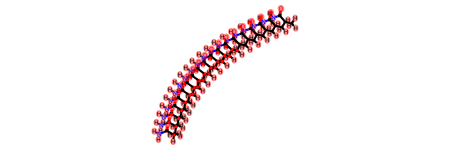

In [7]:
from polysaccharide.molutils.rdmol import rdcompare

offmol = polymer.offmol
rdmol = offmol.to_rdkit()

oe_mol = polymer.charged_offmol_from_sdf('ABE10_exact')
rct_mol = polymer.charged_offmol_from_sdf('ABE10_averaged')
oe_rdmol = oe_mol.to_rdkit()
rct_rdmol = rct_mol.to_rdkit()

diff_mol = rdcompare.difference_rdmol(oe_rdmol, rct_rdmol)
diff_mol


In [15]:
iso = rdmol.GetSubstructMatch(diff_mol)
for atom_id, diff_atom in zip(iso, diff_mol.GetAtoms()):
    rd_atom = rdmol.GetAtomWithIdx(atom_id)
    off_atom = offmol.atoms[atom_id]
    assert(off_atom.symbol == rd_atom.GetSymbol())

    delta_q = diff_atom.GetDoubleProp('DeltaPartialCharge')
    if abs(delta_q) > 0.1:
        print(atom_id, delta_q, off_atom.metadata['residue_number'])

114 0.3209710121154785 12
130 0.15428100526332855 14
132 -0.8395580053329468 14
133 0.1528799831867218 14
134 0.415351003408432 14


## Removing fields from XML (useful for annoying barostat in OpenMM states)

In [ ]:
import xml.etree.ElementTree as ET

for sim_dir, sim_paths_file in pdir.simulation_paths.items():
    sim_paths = SimulationPaths.from_file(sim_paths_file)
    chk = sim_paths.checkpoint
    if chk.suffix == '.xml':
        tree = ET.parse(sim_paths.checkpoint)
        root = tree.getroot()

        par = next(root.iter('Parameters'))
        par.clear()

## Testing dynamic checkpoint file updating

In [ ]:
import pickle

class Test:
    def __init__(self, val : int, checkpoint : Path) -> None:
        self.val = val
        self.checkpoint_path = checkpoint

    def to_file(self):
        if hasattr(self, 'checkpoint_path'):
            with self.checkpoint_path.open('wb') as file:
                pickle.dump(self, file)

    def __setattr__(self, __name: str, __value: Any) -> None:
        super().__setattr__(__name, __value)
        self.to_file()
        print(__name, __value)

In [ ]:
p = Path('test.pkl')
p.touch()

t = Test(5, p)
t.other = 'word'

In [ ]:
with p.open('rb') as file:
    v = pickle.load(file)

v.__dict__
v.foo = 'bar'

## Experimenting with grid size optimization WRT aspect and number of squares

In [ ]:
from math import ceil, sqrt, floor

def size_penalty(N_targ : int, N_real : int) -> float:
    return (N_real / N_targ - 1)**2

def aspect_penalty(a_targ : float, a_real : float) -> float:
    # return (a_real / a_targ - 1)**2
    return 1 - min(a_targ / a_real, a_real / a_targ)

def dims(N : int, a : float=1/1, w1=1, w2=1) -> tuple[int, int]:
    '''Given a particular number of cells and an aspect ratio, yields the smallest 2x2 grid dimensions which accomodate at least N grid squares whose aspect ratio is closest to the '''
    return min( 
        ((r, ceil(N / r))
            for r in range(1, N + 1)
        ),
        key=lambda dims : w1*size_penalty(N, dims[0]*dims[1]) + w2*aspect_penalty(a, dims[0]/dims[1])
    )

a = 2/1
for N in range(1, 20):
    nrows, ncols = dims(N, a)
    fig, ax = plotutils.presize_subplots(nrows=nrows, ncols=ncols, scale=1)
    fig.suptitle(f'N = {N}')